In [111]:
from datasets import load_from_disk
from pprint import pprint
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import scipy.stats as stats
import numpy as np

In [6]:
rewards=load_from_disk("REBEL/rewards")

In [7]:
rewards.shape

(2522, 42)

In [8]:
import pandas as pd

In [9]:
df=rewards.to_pandas()

In [10]:
df.head()
resp_cols=[col for col in df.columns if "by_objective" in col]
#df["response_mixtral-8x7b-instruct_by_objective"][0]

In [11]:
resp_cols

['response_mixtral-8x7b-instruct_by_objective',
 'response_mistral-small_by_objective',
 'response_mistral-medium_by_objective',
 'response_gpt-3.5-turbo-0125_by_objective',
 'response_mistral-large_by_objective',
 'response_gpt-4-turbo-2024-04-09_by_objective',
 'response_claude-3-opus-20240229_by_objective',
 'response_claude-3-sonnet-20240229_by_objective',
 'response_command-r_by_objective',
 'response_command-r-plus_by_objective',
 'response_claude-3-haiku-20240307_by_objective',
 'response_dbrx-instruct_by_objective',
 'response_llama-3-70b-instruct_by_objective']

In [12]:
chars=list(df[resp_cols[0]][0].keys())
chars

['argilla-judge_lm',
 'argilla-overall_quality',
 'beavertails-is_safe',
 'code-complexity',
 'code-explanation',
 'code-instruction-following',
 'code-readability',
 'code-style',
 'helpsteer-coherence',
 'helpsteer-complexity',
 'helpsteer-correctness',
 'helpsteer-helpfulness',
 'helpsteer-verbosity',
 'prometheus-score',
 'ultrafeedback-helpfulness',
 'ultrafeedback-honesty',
 'ultrafeedback-instruction_following',
 'ultrafeedback-overall_score',
 'ultrafeedback-truthfulness']

In [13]:
df.head()

,prompt_uid,prompt_category,prompt,claude-3-haiku-20240307_response,claude-3-opus-20240229_response,claude-3-sonnet-20240229_response,command-r_response,command-r-plus_response,dbrx-instruct_response,gpt-3.5-turbo-0125_response,...,response_command-r_reward,response_command-r_by_objective,response_command-r-plus_reward,response_command-r-plus_by_objective,response_claude-3-haiku-20240307_reward,response_claude-3-haiku-20240307_by_objective,response_dbrx-instruct_reward,response_dbrx-instruct_by_objective,response_llama-3-70b-instruct_reward,response_llama-3-70b-instruct_by_objective
0,001067e0-ff84-4b3f-b840-8ef0f4785c2a,asking_how_to_question,How to film at night with a professional camera,Here are some tips for filming at night with a...,Filming at night with a professional camera re...,Filming at night with a professional camera re...,Filming at night can be a fun and challenging ...,Filming at night can be a challenging but rewa...,1. Choose the right camera: Use a camera with ...,Filming at night with a professional camera ca...,...,0.177734,"{'argilla-judge_lm': 0.000827789306640625, 'ar...",0.189453,"{'argilla-judge_lm': 0.000827789306640625, 'ar...",0.185547,"{'argilla-judge_lm': 0.000919342041015625, 'ar...",0.171875,"{'argilla-judge_lm': 0.00086212158203125, 'arg...",0.204102,"{'argilla-judge_lm': 0.000888824462890625, 'ar..."
1,002b8bbe-0645-4e30-a98f-f2a174ec9778,text_correction,Tell me if the sentence is grammatical. If it ...,The sentence is grammatical. It is correct as ...,yes,"Yes, the sentence is grammatical.","Yes, the sentence is grammatical.",Yes.,"Yes, the sentence is grammatically correct. It...",Yes,...,0.132812,"{'argilla-judge_lm': 0.015380859375, 'argilla-...",0.146484,"{'argilla-judge_lm': 0.015380859375, 'argilla-...",0.122559,"{'argilla-judge_lm': 0.0159912109375, 'argilla...",0.131836,"{'argilla-judge_lm': 0.015869140625, 'argilla-...",0.107910,"{'argilla-judge_lm': 0.0155029296875, 'argilla..."
2,0087bf2b-c661-4b50-8d92-80d986127317,verifying_fact,does t-test requires normal distribution?,"Yes, the t-test does require the underlying da...",The t-test is a parametric test that makes cer...,"Yes, the t-test assumes that the data follows ...","Yes, the t-test does have some requirements re...",The t-test is a commonly used statistical hypo...,The t-test is a commonly used statistical test...,The t-test assumes that the data is normally d...,...,0.161133,"{'argilla-judge_lm': 0.000225067138671875, 'ar...",0.157227,"{'argilla-judge_lm': 0.0002346038818359375, 'a...",0.157227,"{'argilla-judge_lm': 0.000225067138671875, 'ar...",0.173828,"{'argilla-judge_lm': 0.000225067138671875, 'ar...",0.187500,"{'argilla-judge_lm': 0.000225067138671875, 'ar..."
3,00892909-2604-4b57-b402-771b7e0c6232,writing_cooking_recipe,Give a good recipe for hot chocolate using mil...,Here is a recipe for a delicious 18th century-...,Here's a recipe for a rich and flavorful hot c...,Here's a recipe for a rich and decadent hot ch...,"For a delicious, spicy hot chocolate drink wit...",Here is a recipe for a rich and spicy hot choc...,18th Century Style Spiced Hot Chocolate Recipe...,Ingredients:\n- 2 cups of whole milk\n- 2 tabl...,...,0.200195,"{'argilla-judge_lm': 0.00135040283203125, 'arg...",0.202148,"{'argilla-judge_lm': 0.0013275146484375, 'argi...",0.192383,"{'argilla-judge_lm': 0.00135040283203125, 'arg...",0.190430,"{'argilla-judge_lm': 0.00135040283203125, 'arg...",0.223633,"{'argilla-judge_lm': 0.0012664794921875, 'argi..."
4,00a8c7a5-4e4a-44bc-9302-01eac520450d,solving_exam_question_without_math,What weights more on the same point on the sur...,"On the surface of the Earth, 10 kg of feathers...",This is a classic trick question! The answer i...,The weight of an object on the surface of the ...,10kg of feathers. They both weigh the same any...,Both the 10 kg of feathers and the 1 kg of lea...,10kg of feathers and 1kg of lead both have the...,Both 10kg of feathers and 1kg of lead would we...,...,0.070801,"{'argilla-judge_

In [14]:
df.shape

(2522, 42)

In [15]:
# получим среднее значение метрики по модели и категории запроса 
records=[]
for col in resp_cols:
    model_name = col.replace('response_', '').replace('_by_objective', '')
    temp_df = df[['prompt_category', col]].copy()
    temp_df['model'] = model_name
    temp_df = temp_df.dropna(subset=[col])  # Убираем строки с None
    # Разворачиваем словари метрик в столбцы
    temp_df = temp_df.join(temp_df[col].apply(pd.Series))
    temp_df = temp_df.drop(columns=[col])
    records.append(temp_df)

# Шаг 2: объединяем всё
metrics_df = pd.concat(records, ignore_index=True)

# Шаг 3: группируем и берём среднее
agg_df = metrics_df.groupby(['prompt_category', 'model']).mean(numeric_only=True).reset_index()



In [16]:
agg_df.head()

,prompt_category,model,argilla-judge_lm,argilla-overall_quality,beavertails-is_safe,code-complexity,code-explanation,code-instruction-following,code-readability,code-style,...,helpsteer-complexity,helpsteer-correctness,helpsteer-helpfulness,helpsteer-verbosity,prometheus-score,ultrafeedback-helpfulness,ultrafeedback-honesty,ultrafeedback-instruction_following,ultrafeedback-overall_score,ultrafeedback-truthfulness
0,analyzing_general,claude-3-haiku-20240307,0.001920,0.001260,0.000054,0.169898,0.000065,0.002111,9.190194e-07,0.000003,...,0.003733,4.055170e-07,0.041394,0.653793,0.000028,1.897401e-07,0.047190,0.078369,0.000149,1.515140e-07
1,analyzing_general,claude-3-opus-20240229,0.001936,0.001409,0.000056,0.169638,0.000065,0.002228,9.183524e-07,0.000003,...,0.003904,4.067070e-07,0.041272,0.654108,0.000029,1.912429e-07,0.047160,0.078251,0.000150,1.541624e-07
2,analyzing_general,claude-3-sonnet-20240229,0.001933,0.001271,0.000055,0.169670,0.000065,0.002127,9.185566e-07,0.000003,...,0.003755,4.073055e-07,0.041271,0.654486,0.000029,1.914551e-07,0.047178,0.078164,0.000149,1.530588e-07
3,analyzing_general,command-r,0.001930,0.001245,0.000054,0.169827,0.000065,0.002106,9.297608e-07,0.000003,...,0.003695,4.091306e-07,0.041370,0.654045,0.000029,1.930747e-07,0.047259,0.078271,0.000150,1.555325e-07
4,analyzing_general,command-r-plus,0.001929,0.001287,0.000054,0.169630,0.000065,0.002133,9.171450e-07,0.000003,...,0.003746,4.029580e-07,0.041141,0.654612,0.000029,1.903958e-07,0.047204,0.078078,0.000149,1.534229e-07


In [17]:
agg_df.dtypes

prompt_category                         object
model                                   object
argilla-judge_lm                       float64
argilla-overall_quality                float64
beavertails-is_safe                    float64
code-complexity                        float64
code-explanation                       float64
code-instruction-following             float64
code-readability                       float64
code-style                             float64
helpsteer-coherence                    float64
helpsteer-complexity                   float64
helpsteer-correctness                  float64
helpsteer-helpfulness                  float64
helpsteer-verbosity                    float64
prometheus-score                       float64
ultrafeedback-helpfulness              float64
ultrafeedback-honesty                  float64
ultrafeedback-instruction_following    float64
ultrafeedback-overall_score            float64
ultrafeedback-truthfulness             float64
dtype: object

## посмотрим на среднее по pivot пары prompt_category -char

In [91]:
# Шаг 1: «длинный» формат из agg_df
long_df = agg_df.melt(
    id_vars=['prompt_category', 'model'], 
    var_name='metric', 
    value_name='value'
)

# Шаг 2: группируем по prompt_category и metric, усредняем только столбец "value"
avg_per_category = (
    long_df
    .groupby(['prompt_category', 'metric'])['value']   # <-- берём только этот столбец
    .mean()
    .reset_index()
)

# Шаг 3: сводим в pivot, где строки — prompt_category, столбцы — metric, значения — среднее value
pivot_result = avg_per_category.pivot(
    index='prompt_category',
    columns='metric',
    values='value'
)



to_show = pivot_result.sum().reset_index()
to_show.columns = ['metric', 'value']

print(pivot_result.shape)
pivot_result.head()

(56, 19)


metric,argilla-judge_lm,argilla-overall_quality,beavertails-is_safe,code-complexity,code-explanation,code-instruction-following,code-readability,code-style,helpsteer-coherence,helpsteer-complexity,helpsteer-correctness,helpsteer-helpfulness,helpsteer-verbosity,prometheus-score,ultrafeedback-helpfulness,ultrafeedback-honesty,ultrafeedback-instruction_following,ultrafeedback-overall_score,ultrafeedback-truthfulness
prompt_category,,,,,,,,,,,,,,,,,,,
analyzing_general,0.001932,0.001294,0.000055,0.169776,0.000065,0.002134,9.214688e-07,3.182653e-06,1.015884e-05,0.003771,4.069481e-07,0.041308,0.654069,2.863309e-05,1.912420e-07,0.047206,0.078239,0.000150,1.537932e-07
asking_how_to_question,0.001208,0.000263,0.000025,0.149524,0.000060,0.000980,1.904809e-06,6.837010e-06,1.072463e-05,0.001160,1.047312e-06,0.056278,0.658251,2.153120e-05,4.465459e-07,0.052233,0.079731,0.000207,4.148782e-07
brainstorming,0.000836,0.000208,0.000009,0.170621,0.000028,0.000605,5.992142e-07,2.405597e-06,3.728632e-06,0.000911,2.875783e-07,0.046951,0.657320,8.486985e-06,1.155006e-07,0.043371,0.079053,0.000094,1.012786e-07
chitchat,0.001896,0.000051,0.000002,0.087347,0.000003,0.000163,7.274092e-08,4.095520e-07,4.368178e-07,0.001492,4.546953e-08,0.041372,0.767438,6.278635e-07,1.865406e-08,0.047030,0.053172,0.000074,1.425632e-08
classification_identification,0.016383,0.006270,0.000666,0.063933,0.003289,0.008222,7.433148e-07,1.484957e-06,7.721537e-04,0.028050,1.447667e-07,0.007094,0.767598,3.157581e-03,1.328387e-07,0.064167,0.030209,0.000120,8.360131e-08


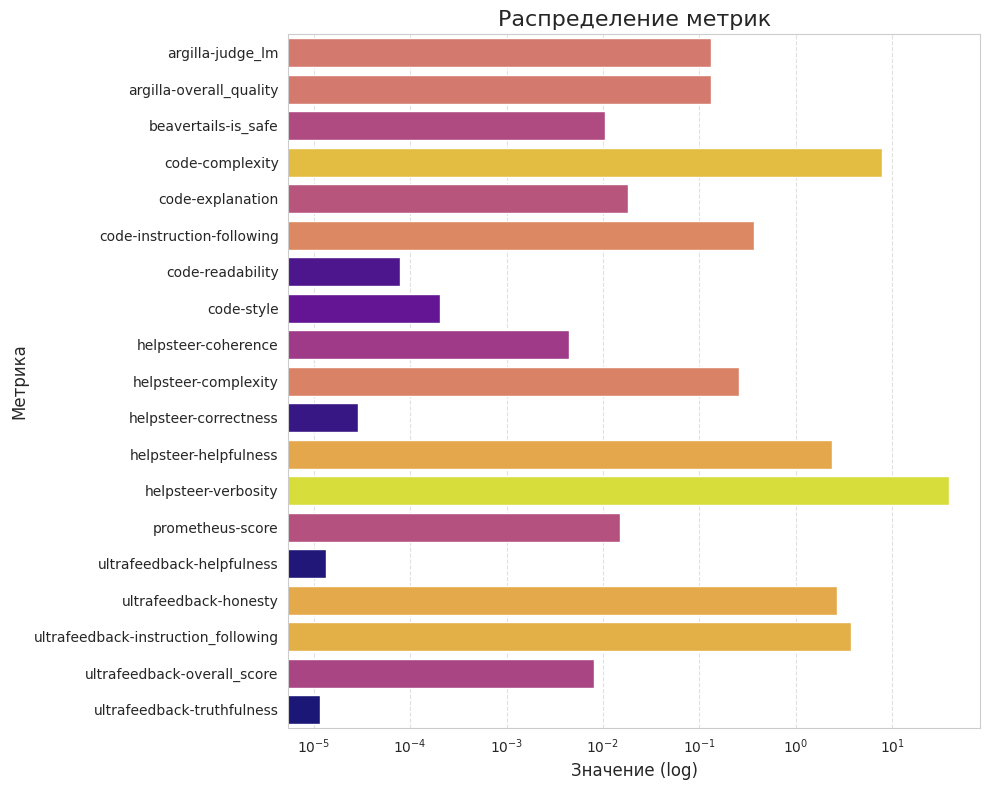

In [92]:
sns.set_style('whitegrid')

# Нормировка по лог-шкале
norm = LogNorm(vmin=to_show['value'].min(), vmax=to_show['value'].max())
colors = cm.plasma(norm(to_show['value'].values))  # замени plasma на любую cmap
colors = colors.tolist()  # чтобы palette принимал список, а не numpy-array

plt.figure(figsize=(10, 8))
sns.barplot(
    data=to_show,
    y='metric',
    x='value',
    palette=colors,
    hue='metric',     # чтобы Seaborn понял, по каким объектам раскрашивать
    legend=False      # отключаем легенду, т.к. цвет сама по себе информативна
)
plt.xscale('log')
plt.title('Распределение метрик', fontsize=16)
plt.xlabel('Значение (log)', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [52]:
pivot_result.index

Index(['analyzing_general', 'asking_how_to_question', 'brainstorming',
       'chitchat', 'classification_identification',
       'code_correction_rewriting', 'code_generation', 'code_simplification',
       'code_to_code_translation', 'counterfactual', 'creative_writing',
       'data_analysis', 'explaining_code', 'explaining_general',
       'functional_writing', 'information_extraction',
       'instructional_rewriting', 'keywords_extraction', 'language_polishing',
       'math_reasoning', 'note_summarization', 'open_question', 'paraphrasing',
       'planning', 'question_generation', 'ranking', 'reading_comprehension',
       'recommendation', 'roleplay', 'seeking_advice',
       'solving_exam_question_with_math', 'solving_exam_question_without_math',
       'text_correction', 'text_simplification', 'text_summarization',
       'text_to_text_translation', 'title_generation', 'topic_modeling',
       'value_judgement', 'verifying_fact', 'writing_advertisement',
       'writing_biogr

In [ ]:

agg_df.loc[agg_df.prompt_category == topic]

,prompt_category,model,argilla-judge_lm,argilla-overall_quality,beavertails-is_safe,code-complexity,code-explanation,code-instruction-following,code-readability,code-style,...,helpsteer-complexity,helpsteer-correctness,helpsteer-helpfulness,helpsteer-verbosity,prometheus-score,ultrafeedback-helpfulness,ultrafeedback-honesty,ultrafeedback-instruction_following,ultrafeedback-overall_score,ultrafeedback-truthfulness
78,code_generation,claude-3-haiku-20240307,0.001399,0.015735,0.000103,0.117790,0.000064,0.021730,0.000001,0.000005,...,0.008610,7.383679e-07,0.045617,0.685807,0.000018,3.270156e-07,0.050023,0.052805,0.000312,2.627674e-07
79,code_generation,claude-3-opus-20240229,0.001402,0.015973,0.000104,0.117887,0.000064,0.021784,0.000001,0.000005,...,0.008723,7.309197e-07,0.045859,0.684635,0.000018,3.230195e-07,0.050148,0.053007,0.000314,2.604353e-07
80,code_generation,claude-3-sonnet-20240229,0.001405,0.016104,0.000106,0.117944,0.000065,0.021788,0.000001,0.000005,...,0.008785,7.423527e-07,0.045642,0.684701,0.000018,3.288566e-07,0.050066,0.052788,0.000313,2.630527e-07
81,code_generation,command-r,0.001406,0.015975,0.000104,0.118026,0.000064,0.021780,0.000001,0.000005,...,0.008709,7.332882e-07,0.045605,0.685026,0.000018,3.260467e-07,0.050083,0.052951,0.000313,2.615752e-07
82,code_generation,command-r-plus,0.001406,0.015922,0.000104,0.118132,0.000064,0.021635,0.000001,0.000005,...,0.008710,7.252753e-07,0.045551,0.685221,0.000018,3.215664e-07,0.050128,0.052943,0.000312,2.571145e-07
83,code_generation,dbrx-instruct,0.001412,0.015886,0.000104,0.117952,0.000064,0.021487,0.000001,0.000005,...,0.008732,7.318721e-07,0.045620,0.685156,0.000018,3.252900e-07,0.050110,0.052991,0.000313,2.606603e-07
84,code_generation,gpt-3.5-turbo-0125,0.001406,0.015831,0.000103,0.118384,0.000065,0.021391,0.000001,0.000005,...,0.008669,7.378084e-07,0.045804,0.684766,0.000018,3.269094e-07,0.050203,0.053252,0.000313,2.637950e-07
85,code_generation,gpt-4-turbo-2024-04-09,0.001413,0.016091,0.000105,0.117928,0.000064,0.021843,0.000001,0.000005,...,0.008766,7.406426e-07,0.045632,0.684505,0.000018,3.283090e-07,0.050162,0.052961,0.000314,2.639999e-07
86,code_generation,llama-3-70b-instruct,0.001410,0.015819,0.000105,0.118058,0.000065,0.021610,0.000001,0.000005,...,0.008678,7.407346e-07,0.045742,0.684896,0.000018,3.289497e-07,0.050256,0.053113,0.000312,2.627482e-07
87,code_generation,mistral-large,0.001396,0.015950,0.000104,0.118319,0.000064,0.021625,0.000001,0.000005,...,0.008681,7.313617e-07,0.045726,0.684245,0.000018,3.223851e-07,0.050248,0.053186,0.000313,2.594242e-07


In [68]:
code_topics=['code_generation', 'code_correction_rewriting', 'code_simplification',
        'explaining_code', 'code_to_code_translation']
topic=code_topics[0]
agg_df.loc[agg_df.prompt_category == topic]["code-explanation"].mean()


np.float64(6.443925010852323e-05)

In [66]:
topic=code_topics[3]
agg_df.loc[agg_df.prompt_category == topic]['code-explanation'].mean()

np.float64(2.7849009403815634e-05)

In [70]:
len(resp_cols)

13

In [43]:
#df[df["prompt_category"]=="code_generation"]

In [44]:
from pprint import pprint

print(df.loc[22]["prompt"])
pprint(df.loc[22]["response_llama-3-70b-instruct_by_objective"])


Can you write a unit test for this go function?

// IsZeroValue checks if the val is the zero-ed value.
func IsZeroValue(val interface{}) bool {
 return val == nil || reflect.DeepEqual(val, reflect.Zero(reflect.TypeOf(val)).Interface())
}
{'argilla-judge_lm': 0.0003757476806640625,
 'argilla-overall_quality': 0.00157928466796875,
 'beavertails-is_safe': 3.838539123535156e-05,
 'code-complexity': 0.0859375,
 'code-explanation': 4.076957702636719e-05,
 'code-instruction-following': 0.023193359375,
 'code-readability': 2.9243528842926025e-07,
 'code-style': 1.3932585716247559e-06,
 'helpsteer-coherence': 2.950429916381836e-06,
 'helpsteer-complexity': 0.000820159912109375,
 'helpsteer-correctness': 1.1455267667770386e-07,
 'helpsteer-helpfulness': 0.0400390625,
 'helpsteer-verbosity': 0.76953125,
 'prometheus-score': 8.046627044677734e-06,
 'ultrafeedback-helpfulness': 3.958120942115784e-08,
 'ultrafeedback-honesty': 0.0380859375,
 'ultrafeedback-instruction_following': 0.04150390625,
 'u

можно заметить что единственный параметр на verbosity занимает 2/3 всех весов 

возможно это связано с тем что модели надо куда то скидывать все ненужные веса как с attention sink 
https://arxiv.org/pdf/2309.17453 а возможно verbosity требует другого подхода  и поэтому требует большого влияние на скор а возможно и что текущие модели просто перетюнены на verbosity

In [19]:
df.prompt_category.unique()

array(['asking_how_to_question', 'text_correction', 'verifying_fact',
       'writing_cooking_recipe', 'solving_exam_question_without_math',
       'instructional_rewriting', 'title_generation',
       'functional_writing', 'writing_social_media_post',
       'text_simplification', 'writing_song_lyrics', 'math_reasoning',
       'explaining_code', 'recommendation', 'text_summarization',
       'open_question', 'ranking', 'roleplay', 'code_generation',
       'creative_writing', 'counterfactual', 'brainstorming',
       'analyzing_general', 'code_correction_rewriting',
       'explaining_general', 'classification_identification',
       'writing_personal_essay', 'writing_legal_document',
       'information_extraction', 'writing_presentation_script',
       'writing_technical_document', 'writing_blog_post',
       'reading_comprehension', 'text_to_text_translation',
       'keywords_extraction', 'paraphrasing', 'code_simplification',
       'language_polishing', 'planning',
       'solv

## обьединим по схожим темам и моделям

In [45]:
import pandas as pd

families = {
    "education": [
        'asking_how_to_question', 'verifying_fact', 'solving_exam_question_without_math',
        'solving_exam_question_with_math', 'math_reasoning', 'reading_comprehension',
        'explaining_general', 'instructional_rewriting'
    ],
    "code": [
        'code_generation', 'code_correction_rewriting', 'code_simplification',
        'explaining_code', 'code_to_code_translation'
    ],
    "writing": [
        'creative_writing', 'functional_writing', 'writing_presentation_script',
        'writing_technical_document', 'writing_blog_post', 'writing_legal_document',
        'writing_personal_essay', 'writing_scientific_paper', 'writing_news_article',
        'writing_job_application', 'writing_advertisement', 'writing_email',
        'writing_biography', 'writing_product_description', 'writing_marketing_materials',
        'writing_social_media_post', 'writing_song_lyrics', 'writing_cooking_recipe','title_generation', 'question_generation'
    ],
    "text_transformation": [
        'text_correction', 'paraphrasing', 'text_simplification',
        'language_polishing', 'text_to_text_translation'
    ],
    "summarization": [
        'text_summarization', 'note_summarization'
    ],
    "extraction": [
        'keywords_extraction', 'information_extraction', 'topic_modeling'
    ],
    "judgement": [
        'classification_identification', 'value_judgement', 'ranking',
        'counterfactual', 'open_question'
    ],
    "interaction": [
        'roleplay', 'chitchat', 'seeking_advice'
    ],
    "analysis": [
        'data_analysis', 'analyzing_general', 'recommendation', 'planning',"'brainstorming'"
    ],
    
}

df_topic_families = pd.DataFrame([
    {"family": fam, "topic": topic}
    for fam, topics in families.items()
    for topic in topics
])

print(set(df_topic_families.topic.unique())==set(df.prompt_category.unique()))


df_topic_families.head()



False


,family,topic
0,education,asking_how_to_question
1,education,verifying_fact
2,education,solving_exam_question_without_math
3,education,solving_exam_question_with_math
4,education,math_reasoning


In [27]:
# 1) Объединяем agg_df с df_topic_families, получая столбцы:
#    prompt_category, model, <все метрики…>, topic, family
merged = agg_df.merge(
    df_topic_families,
    left_on='prompt_category',
    right_on='topic',
    how='left'
)

# 2) Убираем столбец topic или включаем его в id_vars
# Вариант A: просто удаляем topic
merged = merged.drop(columns=['topic'])

# 3) Переводим в “длинный” формат, раскладывая только метрики (избавляемся от topic)
long = merged.melt(
    id_vars=['family', 'prompt_category', 'model'],
    var_name='metric',
    value_name='value'
)

# 4) Группируем по family и metric, берём среднее только по числовому столбцу value
avg_by_family = (
    long
    .groupby(['family', 'metric'])['value']
    .mean()
    .reset_index()
)

# 5) Pivot: строки — family, столбцы — metric, значения — среднее value
pivot_by_family = avg_by_family.pivot(
    index='family',
    columns='metric',
    values='value'
).reset_index()


pivot_by_family.index=pivot_by_family["family"]




pivot_by_family=pivot_by_family.drop(["family"],axis=1)



pivot_by_family


metric,argilla-judge_lm,argilla-overall_quality,beavertails-is_safe,code-complexity,code-explanation,code-instruction-following,code-readability,code-style,helpsteer-coherence,helpsteer-complexity,helpsteer-correctness,helpsteer-helpfulness,helpsteer-verbosity,prometheus-score,ultrafeedback-helpfulness,ultrafeedback-honesty,ultrafeedback-instruction_following,ultrafeedback-overall_score,ultrafeedback-truthfulness
family,,,,,,,,,,,,,,,,,,,
analysis,0.002874,0.002390,0.000094,0.143010,0.000134,0.003672,1.000618e-06,0.000003,0.000029,0.005528,3.360799e-07,0.051379,0.672916,0.000081,1.591305e-07,0.047940,0.069748,0.000140,1.363316e-07
code,0.000771,0.005513,0.000050,0.095500,0.000033,0.022615,5.058390e-07,0.000002,0.000003,0.003377,2.767387e-07,0.039027,0.755535,0.000009,1.225644e-07,0.036594,0.040816,0.000166,9.411859e-08
education,0.003294,0.006662,0.000735,0.126203,0.001012,0.019532,7.481683e-07,0.000003,0.000078,0.011590,3.747485e-07,0.028905,0.693306,0.000857,1.971689e-07,0.050423,0.057238,0.000163,1.554740e-07
extraction,0.005111,0.005046,0.000205,0.131296,0.000610,0.007345,8.171477e-07,0.000003,0.000051,0.011141,4.057147e-07,0.019226,0.707826,0.000459,2.414359e-07,0.051302,0.060342,0.000164,1.789489e-07
interaction,0.001452,0.000474,0.000012,0.116293,0.000028,0.000740,1.389444e-06,0.000003,0.000007,0.001696,4.502218e-07,0.053330,0.715445,0.000009,1.702912e-07,0.046632,0.063837,0.000104,1.690560e-07
judgement,0.004653,0.001683,0.000147,0.132390,0.000685,0.002846,5.096194e-07,0.000002,0.000157,0.007709,2.233416e-07,0.029355,0.703478,0.000640,1.163748e-07,0.052516,0.063649,0.000113,8.937611e-08
summarization,0.005400,0.001106,0.000354,0.138598,0.000480,0.002965,1.190324e-05,0.000016,0.000329,0.003687,2.919274e-06,0.045053,0.675908,0.000417,1.306094e-06,0.053205,0.072150,0.000250,1.379444e-06
text_transformation,0.003010,0.001201,0.000305,0.137948,0.000389,0.002848,2.415689e-06,0.000005,0.000398,0.003074,7.929805e-07,0.041258,0.687888,0.000375,3.734074e-07,0.051669,0.069511,0.000187,3.084968e-07
writing,0.001000,0.000332,0.000018,0.162362,0.000045,0.001092,9.918275e-07,0.000004,0.000006,0.001196,4.762131e-07,0.052944,0.656410,0.000015,2.017623e-07,0.046757,0.077686,0.000126,1.704714e-07


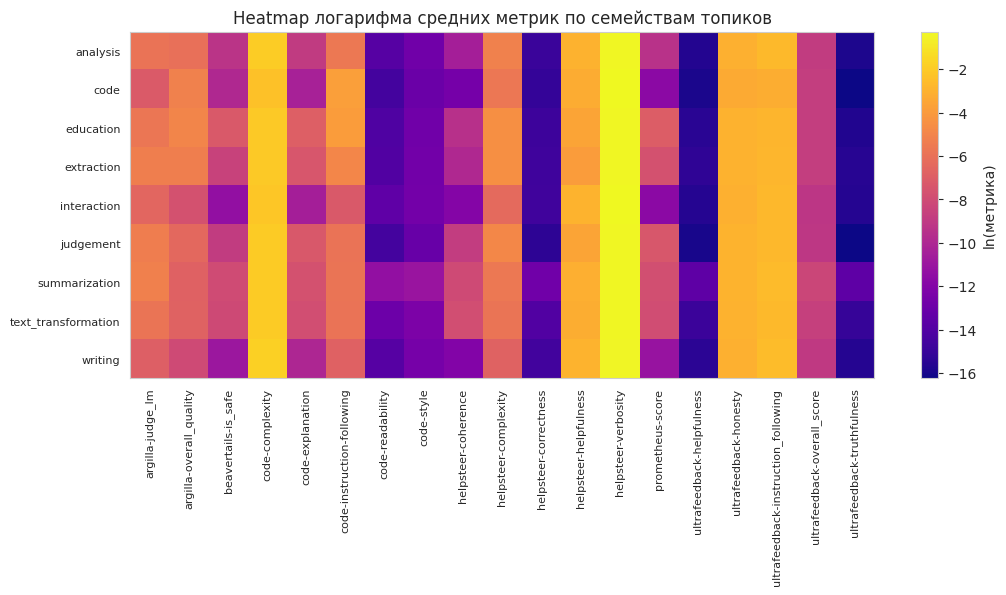

In [122]:
log_df = np.log(pivot_by_family)

# 2. Строим heatmap от логарифма
plt.figure(figsize=(12, log_df.shape[0] * 0.5))
im = plt.imshow(log_df.values, aspect='auto', cmap='plasma')

plt.xticks(
    ticks=range(len(log_df.columns)),
    labels=log_df.columns,
    rotation=90,
    fontsize=8
)
plt.yticks(
    ticks=range(len(log_df.index)),
    labels=log_df.index,
    fontsize=8
)

plt.colorbar(im, label='ln(метрика)')
plt.title('Heatmap логарифма средних метрик по семействам топиков')
plt.grid(False)
plt.show()

In [125]:
pivot_by_family.mean().round(4)

metric
argilla-judge_lm                       0.0031
argilla-overall_quality                0.0027
beavertails-is_safe                    0.0002
code-complexity                        0.1315
code-explanation                       0.0004
code-instruction-following             0.0071
code-readability                       0.0000
code-style                             0.0000
helpsteer-coherence                    0.0001
helpsteer-complexity                   0.0054
helpsteer-correctness                  0.0000
helpsteer-helpfulness                  0.0401
helpsteer-verbosity                    0.6965
prometheus-score                       0.0003
ultrafeedback-helpfulness              0.0000
ultrafeedback-honesty                  0.0486
ultrafeedback-instruction_following    0.0639
ultrafeedback-overall_score            0.0002
ultrafeedback-truthfulness             0.0000
dtype: float64


можно заметить что единственный параметр на verbosity занимает 2/3 всех весов 

возможно это связано с тем что модели надо куда то скидывать все ненужные веса как с attention sink 
https://arxiv.org/pdf/2309.17453 а возможно verbosity требует другого подхода  и поэтому требует большого влияние на скор а возможно и что текущие модели просто перетюнены на verbosity

In [ ]:
pivot_by_family["code-complexity"]

family
analysis               0.143010
code                   0.095500
education              0.126203
extraction             0.131296
interaction            0.116293
judgement              0.132390
summarization          0.138598
text_transformation    0.137948
writing                0.162362
Name: code-complexity, dtype: float64

неожиданно но code-complexity менее важен в задаче code чем в задаче writing 

In [48]:
pivot_by_family["code-explanation"]

family
analysis               0.000134
code                   0.000033
education              0.001012
extraction             0.000610
interaction            0.000028
judgement              0.000685
summarization          0.000480
text_transformation    0.000389
writing                0.000045
Name: code-explanation, dtype: float64

уберем его и посмотрим на распределение по категориям без него

In [ ]:
agg_df.model.unique()

array(['claude-3-haiku-20240307', 'claude-3-opus-20240229',
       'claude-3-sonnet-20240229', 'command-r', 'command-r-plus',
       'dbrx-instruct', 'gpt-3.5-turbo-0125', 'gpt-4-turbo-2024-04-09',
       'llama-3-70b-instruct', 'mistral-large', 'mistral-medium',
       'mistral-small', 'mixtral-8x7b-instruct'], dtype=object)

In [ ]:
families={
    "claude":['claude-3-haiku-20240307', 'claude-3-opus-20240229',
       'claude-3-sonnet-20240229'],
    "command": ['command-r', 'command-r-plus'],
    "dbrx":['dbrx-instruct'],
    "openai":['gpt-3.5-turbo-0125', 'gpt-4-turbo-2024-04-09'],
    "llama":['llama-3-70b-instruct'],
    "mistral" : ['mistral-large', 'mistral-medium',
       'mistral-small', 'mixtral-8x7b-instruct']
}

df_model_families=pd.DataFrame([
    {"family":fam,"model":model}
    for fam , models in families.items()
    for model in models

])
df_model_families

,family,model
0,claude,claude-3-haiku-20240307
1,claude,claude-3-opus-20240229
2,claude,claude-3-sonnet-20240229
3,command,command-r
4,command,command-r-plus
5,dbrx,dbrx-instruct
6,openai,gpt-3.5-turbo-0125
7,openai,gpt-4-turbo-2024-04-09
8,llama,llama-3-70b-instruct
9,mistral,mistral-large


In [ ]:
agg_df.drop().head().iloc[:, :5]

,prompt_category,model,argilla-judge_lm,argilla-overall_quality,beavertails-is_safe
0,analyzing_general,claude-3-haiku-20240307,0.001920,0.001260,0.000054
1,analyzing_general,claude-3-opus-20240229,0.001936,0.001409,0.000056
2,analyzing_general,claude-3-sonnet-20240229,0.001933,0.001271,0.000055
3,analyzing_general,command-r,0.001930,0.001245,0.000054
4,analyzing_general,command-r-plus,0.001929,0.001287,0.000054


In [100]:
metrics

Index(['argilla-judge_lm', 'argilla-overall_quality', 'beavertails-is_safe',
       'code-complexity', 'code-explanation', 'code-instruction-following',
       'code-readability', 'code-style', 'helpsteer-coherence',
       'helpsteer-complexity', 'helpsteer-correctness',
       'helpsteer-helpfulness', 'helpsteer-verbosity', 'prometheus-score',
       'ultrafeedback-helpfulness', 'ultrafeedback-honesty',
       'ultrafeedback-instruction_following', 'ultrafeedback-overall_score',
       'ultrafeedback-truthfulness'],
      dtype='object')

In [ ]:


# 1. Выделим только числовые столбцы метрик (все, кроме 'prompt_category' и 'model'):
metrics = agg_df.columns.drop(['prompt_category', 'model'])



# 3. Аналогично, можно вычислить и стандартное отклонение:
std_by_model = agg_df.groupby('prompt_category')[metrics].std()

mean_by_model=agg_df.groupby('prompt_category')[metrics].mean()

# 4. Если нужно оценить «общую» дисперсию одной метрики (в диапазоне всех моделей),
#    можно взять строку var_by_model.loc[:, <имя_метрики>], 
#    а если наоборот — по одной модели все метрики — var_by_model.loc['имя_модели'].

# 5. Например, вывести таблицу дисперсий и стандартных отклонений:
result = pd.concat(
    {
        "coefficient of variation": std_by_model/mean_by_model
     
    },
    axis=1
)

result.head()


coefficient of variation  \
                                      argilla-judge_lm   
prompt_category                                          
analyzing_general                             0.004579   
asking_how_to_question                        0.013531   
brainstorming                                 0.006340   
chitchat                                      0.009097   
classification_identification                 0.005415   

                                                                           \
                              argilla-overall_quality beavertails-is_safe   
prompt_category                                                             
analyzing_general                            0.036459            0.013525   
asking_how_to_question                       0.011482            0.018975   
brainstorming                                0.014910            0.017774   
chitchat                                     0.020872            0.024971   
classification_identification                0.013211            0.013363   

                                                                \
                              code-complexity code-explanation   
prompt_category                                                  
analyzing_general                    0.000747         0.002971   
asking_how_to_question               0.002214         0.007815   
brainstorming                        0.000695         0.008272   
chitchat                             0.001767         0.020588   
classification_identification        0.004199         0.009911   

                                                                           \
                              code-instruction-following code-readability   
prompt_category                                                             
analyzing_general                               0.017491         0.005472   
asking_how_to_question                          0.009459         0.013339   
brainstorming                                   0.005738         0.005127   
chitchat                                        0.014864         0.013534   
classification_identification                   0.008979         0.023442   

                                                              \
                              code-style helpsteer-coherence   
prompt_category                                                
analyzing_general               0.004307            0.008264   
asking_how_to_question          0.010164            0.018184   
brainstorming                   0.004352            0.018138   
chitchat                        0.011651            0.015452   
classification_identification   0.010355            0.027345   

                                                                          \
                              helpsteer-complexity helpsteer-correctness   
prompt_category                                                            
analyzing_general                         0.017805              0.004705   
asking_how_to_question                    0.011568              0.013985   
brainstorming                             0.016125              0.006961   
chitchat                                  0.020707              0.008294   
classification_identification             0.006776              0.012913   

                                                                         \
                              helpsteer-helpfulness helpsteer-verbosity   
prompt_category                                                           
analyzing_general                          0.001594            0.000372   
asking_how_to_question                     0.001433            0.000739   
brainstorming                              0.001150            0.000304   
chitchat                                   0.002823            0.000283   
classification_identification              0.004933            0.000420   

                                                                          \
   

In [110]:
df.shape
df.columns
df['response_mistral-large_by_objective'][0]

{'argilla-judge_lm': 0.000919342041015625,
 'argilla-overall_quality': 0.00017547607421875,
 'beavertails-is_safe': 1.3947486877441406e-05,
 'code-complexity': 0.134765625,
 'code-explanation': 2.956390380859375e-05,
 'code-instruction-following': 0.000652313232421875,
 'code-readability': 7.860362529754639e-07,
 'code-style': 3.5315752029418945e-06,
 'helpsteer-coherence': 3.5315752029418945e-06,
 'helpsteer-complexity': 0.00110626220703125,
 'helpsteer-correctness': 4.4889748096466064e-07,
 'helpsteer-helpfulness': 0.0634765625,
 'helpsteer-verbosity': 0.671875,
 'prometheus-score': 6.198883056640625e-06,
 'ultrafeedback-helpfulness': 1.5459954738616943e-07,
 'ultrafeedback-honesty': 0.05078125,
 'ultrafeedback-instruction_following': 0.0771484375,
 'ultrafeedback-overall_score': 0.00017547607421875,
 'ultrafeedback-truthfulness': 1.3690441846847534e-07}